In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report


import re
import gensim
import seaborn
import random
import os

In [2]:
EMBEDDINGLENGTH=300

In [3]:
np.random.seed(10)
tf.random.set_seed(2)
random.seed(10)
os.environ['PYTHONHASHSEED'] = str(10)

In [4]:
df_train = pd.read_csv("crisismmd_datasplit_agreed_label/task_informative_text_img_agreed_lab_train.tsv", sep='\t')
df_val = pd.read_csv("crisismmd_datasplit_agreed_label/task_informative_text_img_agreed_lab_dev.tsv", sep='\t')
df_test = pd.read_csv("crisismmd_datasplit_agreed_label/task_informative_text_img_agreed_lab_test.tsv", sep='\t')

In [5]:
df_train = df_train.drop_duplicates(subset="tweet_id")
df_val = df_val.drop_duplicates(subset="tweet_id")
df_test = df_test.drop_duplicates(subset="tweet_id")

In [6]:
#DATA VISUALISATION

In [7]:
def barplots(barlist):
    import matplotlib.pyplot as plt
    plt.bar(['California Wildfires', 'Hurricane Harvey', 'Hurricane Irma', 'Hurricane Maria', 'Iraq-Iran Earthquake'
             , 'Mexico Earthquake', 'Srilanka Floods'], barlist ,color ='maroon')
    plt.ylabel('Number of tweets', {'color':  'purple', 'size': 18})
    plt.xlabel('Disaster', {'color':  'purple', 'size': 18})
    plt.rcParams['figure.facecolor'] = 'white'
    labels = ['California Wildfires', 'Hurricane Harvey', 'Hurricane Irma', 'Hurricane Maria', 'Iraq-Iran Earthquake'
             , 'Mexico Earthquake', 'Srilanka Floods']
    plt.xticks(np.arange(len(labels)), labels, rotation ='45')
    plt.rcParams["figure.figsize"] = (8,6)


In [8]:
count = df_train.groupby(['event_name']).count()
count.iloc[0]['label']

802

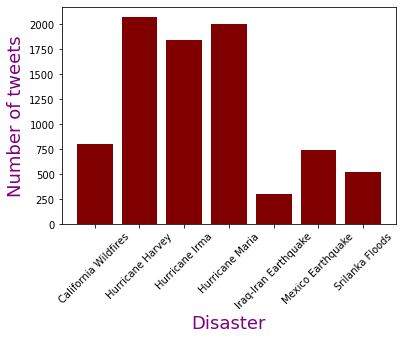

In [9]:
#There are duplicate tweets
# print("California Wildfires:\nNumber of tweets- ",df1.shape[0])
# print("\nHurricane Harvey:\nNumber of tweets- ",df2.shape[0])
# print("\nHurricane Irma:\nNumber of tweets- ",df3.shape[0])
# print("\nHurricane Maria:\nNumber of tweets- ",df4.shape[0])
# print("\nIraq-Iran Earthquake:\nNumber of tweets- ",df5.shape[0])
# print("\nMexico Earthquake:\nNumber of tweets- ",df6.shape[0])
# print("\nSrilanka Floods:\nNumber of tweets- ",df7.shape[0])

barplots([count.iloc[0]['label'],count.iloc[1]['label'],count.iloc[2]['label']
          ,count.iloc[3]['label'],count.iloc[4]['label'],count.iloc[5]['label'],count.iloc[6]['label']])

In [10]:
def barplot2(df):
    seaborn.set_theme(style="darkgrid")
    ax = seaborn.countplot(x="event_name",hue='label_image', data=df)
    labels = ['California Wildfires', 'Hurricane Harvey', 'Hurricane Irma', 'Hurricane Maria', 'Iraq-Iran Earthquake'
         , 'Mexico Earthquake', 'Srilanka Floods']
    ax.set_xticklabels(labels,rotation=45)
    ax.set_xlabel('Disaster Name',fontsize=20, color='blue');
    ax.set_ylabel('Image Label Counts',fontsize=20,  color='blue');




In [11]:
#barplot2(pd.concat([df_train,df_test,df_val]))

In [12]:
def tweetlength(text):
    list = text.split()
    return len(list)

In [13]:
def tweetstats(l):
    return np.array([round(sum(l)/len(l)), min(l), max(l), np.array(l).std()])

In [14]:
def rangeplots(array):
    import matplotlib.pyplot as plt
    import numpy as np

# construct some data like what you have:

    mins = array[1,:]
    maxes = array[2,:]
    means = array[0,:]
    std = array[3,:]
    
    seaborn.set_theme(style="white")

# create stacked errorbars:
    plt.errorbar(np.arange(len(mins)), means, std, fmt='ok', lw=3)
    plt.errorbar(np.arange(len(mins)), means, [means - mins, maxes - means],
             fmt='ok', ecolor='red', lw=1)
    plt.xlim(-1, len(mins))
    plt.ylabel('Tweet length (in words)', {'color':  'green', 'size': 15})
    plt.xlabel('Disaster', {'color':  'green', 'size': 15})
    labels = ['California Wildfires', 'Hurricane Harvey', 'Hurricane Irma', 'Hurricane Maria', 'Iraq-Iran Earthquake'
         , 'Mexico Earthquake', 'Srilanka Floods']
    plt.xticks(np.arange(len(mins)), labels, rotation ='45')
    plt.rcParams["figure.figsize"] = (8,6)
    plt.show()

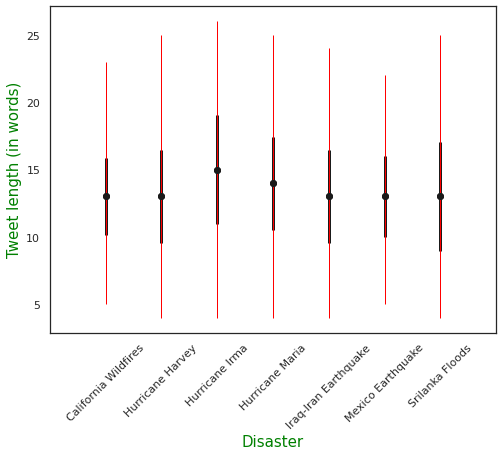

In [15]:
array = np.zeros([4,7])
l1 = df_train[df_train['event_name']=='california_wildfires'].tweet_text.apply(tweetlength)
array[:,0]=tweetstats(l1)
l2 = df_train[df_train['event_name']=='hurricane_harvey'].tweet_text.apply(tweetlength)
array[:,1]=tweetstats(l2)
l3 = df_train[df_train['event_name']=='hurricane_irma'].tweet_text.apply(tweetlength)
array[:,2]=tweetstats(l3)
l4 = df_train[df_train['event_name']=='hurricane_maria'].tweet_text.apply(tweetlength)
array[:,3]=tweetstats(l4)
l5 = df_train[df_train['event_name']=='iraq_iran_earthquake'].tweet_text.apply(tweetlength)
array[:,4]=tweetstats(l5)
l6 = df_train[df_train['event_name']=='mexico_earthquake'].tweet_text.apply(tweetlength)
array[:,5]=tweetstats(l6)
l7 = df_train[df_train['event_name']=='srilanka_floods'].tweet_text.apply(tweetlength)
array[:,6]=tweetstats(l7)
rangeplots(array)
#array=np.column_stack((l1,l2,l3,l4,l5,l6,l7))

In [16]:
df_train.columns

Index(['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label',
       'label_text', 'label_image', 'label_text_image'],
      dtype='object')

In [17]:
def MatchingLabelFilter(df):
    newdf= df.loc[df['text_human'] == df['image_human']]
    newdf.reset_index(inplace = True, drop = True)
    return newdf

In [18]:
# df = pd.concat([df1,df2,df3,df4,df5,df6,df7])
BATCHSIZE=df_train.shape[0]

In [19]:
# df.shape
#df_train

In [20]:
# df = MatchingLabelFilter(df)
# df.shape

In [21]:
df_train= df_train.drop(['tweet_id', 'image_id','image', 'label','label_image'], axis=1)
df_val= df_val.drop(['tweet_id', 'image_id','image', 'label','label_image'], axis=1)
df_test= df_test.drop(['tweet_id', 'image_id','image', 'label','label_image'], axis=1)

In [22]:
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

In [23]:
df_train.shape

(8293, 4)

In [24]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
#print(stop_words)

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]+"

In [25]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if (token not in stop_words and (len(token)!=1) and token not in ["rt","RT"]):
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
        #The join() method takes all items in an iterable and joins them into one string.
  return " ".join(tokens)

In [26]:
df_train.tweet_text = df_train.tweet_text.apply(preprocess)
df_val.tweet_text = df_val.tweet_text.apply(preprocess)
df_test.tweet_text = df_test.tweet_text.apply(preprocess)

In [27]:
# from wordcloud import WordCloud, STOPWORDS
# stopwords = set(STOPWORDS)

# def show_wordcloud(data):
#     wordcloud = WordCloud(
#         background_color='white',
#         stopwords=stopwords,
#         max_words=100,
#         max_font_size=30,
#         scale=3,
#         random_state=1)
   
#     wordcloud=wordcloud.generate(str(data))

#     fig = plt.figure(1, figsize=(12, 12))
#     plt.axis('off')

#     plt.imshow(wordcloud)
#     plt.show()
# string = " ".join(df.tweet_text.tolist())
# show_wordcloud(string)

In [28]:
#https://en.wikipedia.org/wiki/Word2vec#CBOW_and_skip_grams
#https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314
#https://arxiv.org/pdf/1411.2738.pdf

In [29]:
#DATARATIO=0.85

In [30]:
#df_train, df_test = train_test_split(df, test_size=1-DATARATIO, random_state=13)   #Scikit

In [31]:
#df_train.tweet_text[0]

In [32]:
#WORD2VEC

In [33]:
documents = [_text.split() for _text in df_train.tweet_text]

In [34]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [35]:
w2v_model = gensim.models.Word2Vec(vector_size=EMBEDDINGLENGTH, 
                                   window=2, 
                                   min_count=1, 
                                   workers=cores-2,
                                   sg=1)

In [36]:
w2v_model.save("w2v_model.model")

w2v_model.build_vocab(documents)
wordvectors = w2v_model.wv    #keyed vector object
print("Vocab size:", len(wordvectors))

Vocab size: 14909


In [37]:
wordvectors.most_similar("fire")

[('devos', 0.24337470531463623),
 ('congculberson', 0.21374689042568207),
 ('castro', 0.2050253003835678),
 ('buymigenteremix', 0.20345653593540192),
 ('wish', 0.20081742107868195),
 ('nobody', 0.19909629225730896),
 ('jalopnik', 0.19623886048793793),
 ('reviews', 0.1952628791332245),
 ('scandal', 0.19266308844089508),
 ('04924', 0.1883985847234726)]

In [38]:
w2v_model.train(documents, total_examples=len(documents), epochs=50)

(3098721, 3544150)

In [39]:
wordvectors.most_similar("fire")

[('fires', 0.6052805185317993),
 ('battling', 0.5916585922241211),
 ('flames', 0.5858626961708069),
 ('santa', 0.5725240707397461),
 ('anaheim', 0.5724551677703857),
 ('obviously', 0.5708611011505127),
 ('dude', 0.5683284401893616),
 ('rest', 0.56723952293396),
 ('melbournenews', 0.5659603476524353),
 ('napafire', 0.5641492605209351)]

In [40]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train.tweet_text)    #creates word_index dictionary based on frequency of the word

vocabularysize = len(tokenizer.word_index) + 1
print("Total words", vocabularysize)

Total words 14910


In [41]:
tokenizer.word_index

{'irma': 1,
 'hurricane': 2,
 'harvey': 3,
 'puerto': 4,
 'rico': 5,
 'earthquake': 6,
 'maria': 7,
 'california': 8,
 'mexico': 9,
 'help': 10,
 'wildfires': 11,
 'amp': 12,
 'mora': 13,
 'relief': 14,
 'victims': 15,
 'storm': 16,
 'new': 17,
 'iran': 18,
 'hurricanemaria': 19,
 'fire': 20,
 'news': 21,
 'florida': 22,
 'tornado': 23,
 'trump': 24,
 'via': 25,
 'hurricaneharvey': 26,
 'us': 27,
 'texas': 28,
 'people': 29,
 'houston': 30,
 'city': 31,
 'still': 32,
 'damage': 33,
 'hit': 34,
 'post': 35,
 'today': 36,
 'back': 37,
 'iraq': 38,
 'one': 39,
 'wildfire': 40,
 'aid': 41,
 'home': 42,
 'could': 43,
 'power': 44,
 'like': 45,
 'recovery': 46,
 'get': 47,
 'update': 48,
 'puertorico': 49,
 'day': 50,
 'water': 51,
 'helping': 52,
 'efforts': 53,
 'flood': 54,
 'gt': 55,
 'affected': 56,
 'watch': 57,
 'disaster': 58,
 'need': 59,
 'first': 60,
 'photos': 61,
 '2017': 62,
 'rescue': 63,
 'tropical': 64,
 'please': 65,
 'mexicoearthquake': 66,
 'caribbean': 67,
 'video': 68,


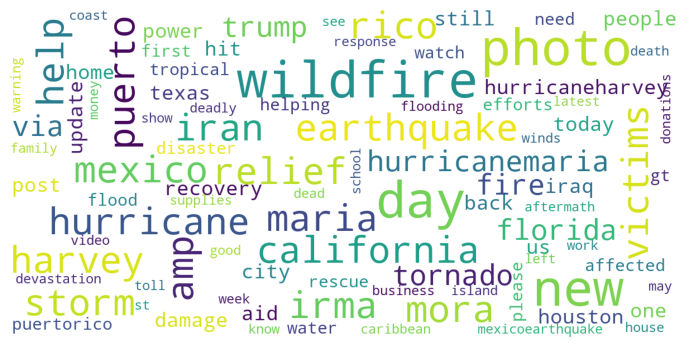

In [42]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

freqwordlist = list(tokenizer.word_index.keys())[:100]

string = " ".join(freqwordlist)
show_wordcloud(string)

In [43]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# X = w2v_model.wv[w2v_model.wv.key_to_index]
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X)
# plt.rcParams["figure.figsize"] = (12,9)

# labels = list(w2v_model.wv.key_to_index.keys())

# for label, x, y in zip(labels, X_tsne[:, 0], X_tsne[:, 1]):
#     if (tokenizer.word_index[label]<200):
#         plt.scatter(x,y,color='blue')
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, -1),
#             textcoords='offset points', ha='left', va='top')
# plt.title(label="t-SNE Plot of Embeddings",
#           fontsize=25,
#           color="green")
# plt.show()

In [44]:
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [45]:
df_train.tweet_text

0       cal oes pls share capturing wildfire response ...
1       kakenews california wildfires destroy 50 struc...
4       theatlantic photos california destructive wild...
7                         california wildfires worse fall
10      playing new friend chai california fire evacue...
                              ...                        
9596    siri rescues sick teen hurricane harvey newyor...
9597    wells fargo atms accepting donations californi...
9598     san juan flights still hold wake hurricane maria
9599    11am maria update tropical storm force winds e...
9600    earthquake mexico rocks ph embassy filipino ca...
Name: tweet_text, Length: 8293, dtype: object

In [46]:
def find_biggest_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

In [47]:
xtrain_sequences = tokenizer.texts_to_sequences(df_train.tweet_text)
xval_sequences = tokenizer.texts_to_sequences(df_val.tweet_text)
xtest_sequences = tokenizer.texts_to_sequences(df_test.tweet_text)
#Tokenizer skips the word if it does not know it

In [48]:
MAXSENTENCELENGTH_train = find_biggest_list(xtrain_sequences)      # sequences will only contain words identified by the tokenizer
MAXSENTENCELENGTH_val = find_biggest_list(xval_sequences)
MAXSENTENCELENGTH_test = find_biggest_list(xval_sequences)
MAXSENTENCELENGTH = max(MAXSENTENCELENGTH_train, MAXSENTENCELENGTH_val, MAXSENTENCELENGTH_test)

In [49]:
xtrain_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(xtrain_sequences, padding="post", maxlen=MAXSENTENCELENGTH)
xval_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(xval_sequences, padding="post", maxlen=MAXSENTENCELENGTH)
xtest_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(xtest_sequences, padding="post", maxlen=MAXSENTENCELENGTH)

In [50]:
# CATEGORICAL TO NUMERICAL ENCODING

In [51]:
# prepare input data
def One_Hot_Encoding(Y_train, Y_val, Y_test):
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(Y_train)
    categoryarray=ohe.categories_
    Y_train_enc = ohe.transform(Y_train)
    Y_test_enc = ohe.transform(Y_test)
    Y_val_enc = ohe.transform(Y_val)
    return categoryarray, Y_train_enc, Y_val_enc, Y_test_enc

In [52]:
categoryarray, ytrain, yval, ytest = One_Hot_Encoding(np.array(df_train.label_text.to_list()).reshape(-1,1), np.array(df_val.label_text.to_list()).reshape(-1,1), np.array(df_test.label_text.to_list()).reshape(-1,1))       # Neural networks expects input values to be numerical.
ytrain = ytrain.toarray()
yval = yval.toarray()
ytest = ytest.toarray()
categoryarray

[array(['informative', 'not_informative'], dtype='<U15')]

In [53]:
noofcategories=len(categoryarray[0])

In [54]:
# EMBEDDING LAYER DEFINITION

In [55]:
embedding_matrix = np.zeros((vocabularysize, EMBEDDINGLENGTH))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(14910, 300)


In [56]:
embedding_layer = tf.keras.layers.Embedding(input_dim=vocabularysize,
                                            output_dim=EMBEDDINGLENGTH,
                                            weights=[embedding_matrix],
                                            input_length=MAXSENTENCELENGTH,
                                            trainable=False)

In [57]:
# MODEL BUILDING

In [58]:

model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
#model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.Dense(noofcategories, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           4473000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 5,307,050
Trainable params: 834,050
Non-trainable params: 4,473,000
_________________________________________________________________


In [59]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(5e-4), metrics=["accuracy"])

In [60]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=10, cooldown=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)]

In [61]:
#TRAIN
xtrain_padded_sequences

array([[1864, 3739, 1257, ...,    0,    0,    0],
       [3741,    8,   11, ...,    0,    0,    0],
       [2800,   61,    8, ...,    0,    0,    0],
       ...,
       [ 145,  223, 1070, ...,    0,    0,    0],
       [1951,    7,   48, ...,    0,    0,    0],
       [   6,    9,  756, ...,    0,    0,    0]], dtype=int32)

In [62]:
H = model.fit(xtrain_padded_sequences, ytrain, batch_size=int(BATCHSIZE/20), epochs=50, validation_data=(xval_padded_sequences, yval), verbose=1, callbacks=callbacks)

Epoch 1/50
21/21 [==============================] - 17s 623ms/step - loss: 0.5743 - accuracy: 0.6856 - val_loss: 0.4194 - val_accuracy: 0.8086
Epoch 2/50
21/21 [==============================] - 11s 531ms/step - loss: 0.4229 - accuracy: 0.8085 - val_loss: 0.4053 - val_accuracy: 0.8214
Epoch 3/50
21/21 [==============================] - 9s 426ms/step - loss: 0.3953 - accuracy: 0.8235 - val_loss: 0.4029 - val_accuracy: 0.8214
Epoch 4/50
21/21 [==============================] - 14s 665ms/step - loss: 0.4054 - accuracy: 0.8176 - val_loss: 0.3992 - val_accuracy: 0.8175
Epoch 5/50
21/21 [==============================] - 14s 698ms/step - loss: 0.3922 - accuracy: 0.8216 - val_loss: 0.3959 - val_accuracy: 0.8188
Epoch 6/50
21/21 [==============================] - 17s 794ms/step - loss: 0.3836 - accuracy: 0.8327 - val_loss: 0.3873 - val_accuracy: 0.8220
Epoch 7/50
21/21 [==============================] - 17s 804ms/step - loss: 0.3669 - accuracy: 0.8402 - val_loss: 0.3825 - val_accuracy: 0.8226


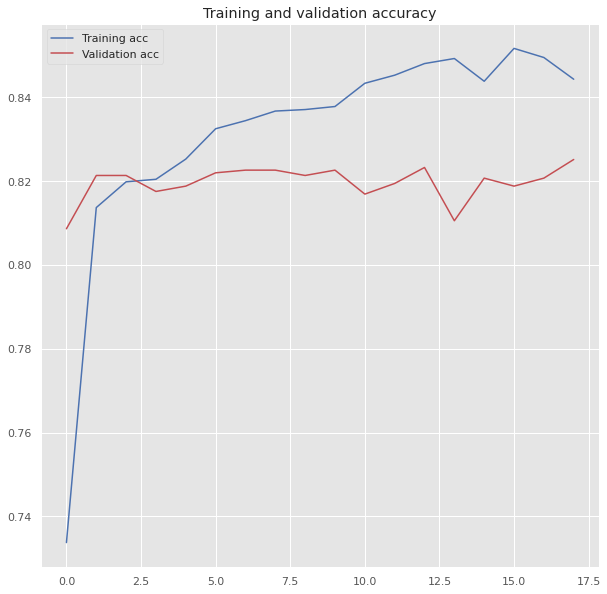

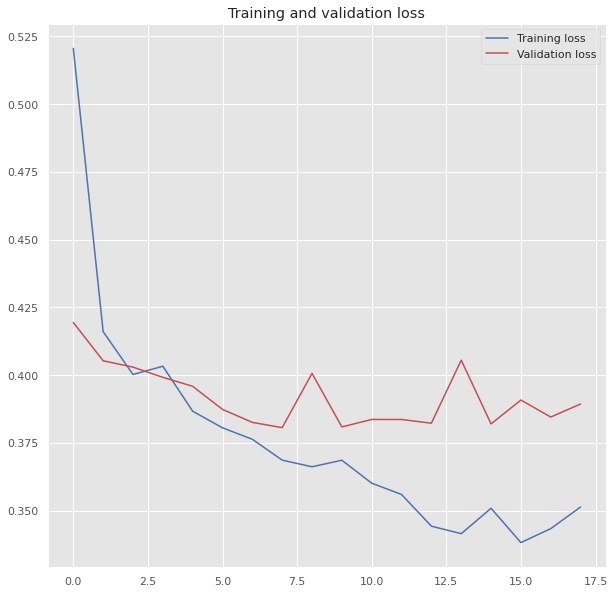

In [63]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
 
epochs = range(len(acc))

plt.style.use("ggplot")
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.rcParams["figure.figsize"] = (5,4)
plt.show()

In [64]:
#TESTING

In [65]:
%%time
score = model.evaluate(xtest_padded_sequences, ytest, batch_size=1024)

print("ACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 1s 372ms/step - loss: 0.3787 - accuracy: 0.8370
ACCURACY: 0.837027370929718
LOSS: 0.3786977529525757
CPU times: user 3.23 s, sys: 132 ms, total: 3.37 s
Wall time: 1.22 s


In [66]:
def singletweetprediction(tweettext, categoryarray):
    wordstring = preprocess(tweettext)
    tokenisedwordlist = tokenizer.texts_to_sequences([wordstring])
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenisedwordlist, padding="post", maxlen=MAXSENTENCELENGTH)
    
#     print(wordstring)
#     print(padded_sequences)
    
    score = model.predict(padded_sequences, batch_size=int(BATCHSIZE/20))    # Score is the probability output of the last layer
    
    x=np.argmax(score[0])
    
    return categoryarray[0][x]

In [67]:
print(singletweetprediction("building d damage fire", categoryarray))

informative


In [68]:
score = model.predict(xtest_padded_sequences, batch_size=int(BATCHSIZE/20))    # Score is the probability output of the last layer

y_pred=[]
for i in score:
    y_pred.append(categoryarray[0][np.argmax(i)])
    
y_true = df_test.label_text.tolist()
# categoryarray

In [69]:
# plt.figure(figsize=(12,12))
# plt.hist(y_true)
# y_true.count('other_relevant_information')

In [70]:
# plt.figure(figsize=(12,12))
# plt.hist(y_pred)

In [71]:
cmatrix = confusion_matrix(y_true, y_pred, labels=categoryarray[0])
np.set_printoptions(precision=2)

In [72]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap='Blues',
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,
          fontsize=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=12)
        plt.yticks(tick_marks, target_names, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.0 if normalize else cm.max() / 4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=18, color='purple')
    plt.xlabel('Predicted label\n\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass),fontsize=18, color='purple')
    plt.rcParams["figure.figsize"] = (8,8)
    plt.rcParams.update({'font.size': 16})
    plt.show()

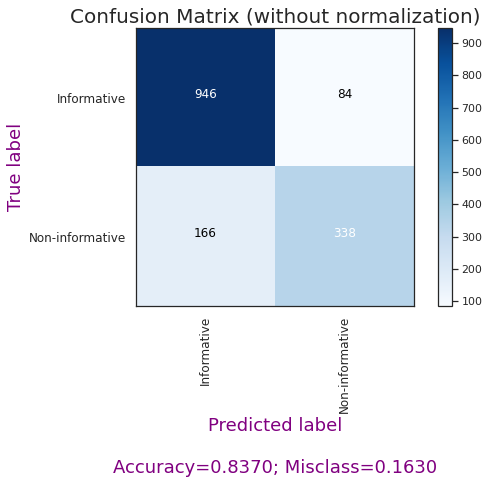

In [73]:
seaborn.set_theme(style="white")
plot_confusion_matrix(cmatrix, ['Informative', 'Non-informative'], title='Confusion Matrix (without normalization)')


In [74]:
print(classification_report(y_true, y_pred, digits=4))

                 precision    recall  f1-score   support

    informative     0.8507    0.9184    0.8833      1030
not_informative     0.8009    0.6706    0.7300       504

       accuracy                         0.8370      1534
      macro avg     0.8258    0.7945    0.8067      1534
   weighted avg     0.8344    0.8370    0.8329      1534

